# 🏎️ Apex F1 — Feature Engineering & Model Exploration

**Dataset:** `laps_data.csv` (Italy 2023 race laps)  
**Goal:** Build a reproducible feature engineering pipeline and compare candidate models for lap-time prediction.

---
## Table of Contents
1. [Load & Inspect](#1-load--inspect)
2. [Null / Missing Value Analysis](#2-null--missing-value-analysis)
3. [Target Engineering — LapTime → seconds](#3-target-engineering)
4. [Univariate Distributions](#4-univariate-distributions)
5. [Correlation Analysis](#5-correlation-analysis)
6. [Encoding & Normalisation](#6-encoding--normalisation)
7. [Model Comparison](#7-model-comparison)
8. [Takeaways & Recommended Pipeline](#8-takeaways)


In [1]:
# ── Imports ──────────────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from scipy import stats

from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
)
from xgboost import XGBRegressor

sns.set_theme(style='darkgrid', palette='tab10')
plt.rcParams['figure.dpi'] = 110
RANDOM_STATE = 42
print('All imports OK ✓')

All imports OK ✓


---
## 1 · Load & Inspect

In [2]:
df_raw = pd.read_csv('laps_data.csv')
print(f'Shape: {df_raw.shape}  ({df_raw.shape[0]:,} laps × {df_raw.shape[1]} columns)')
df_raw.head()

Shape: (958, 6)  (958 laps × 6 columns)


,Driver,LapNumber,LapTime,TyreLife,Compound,PitOutTime
0,VER,1.0,0 days 00:01:27.905000,1.0,MEDIUM,NaN
1,VER,2.0,0 days 00:01:26.163000,2.0,MEDIUM,NaN
2,VER,3.0,0 days 00:01:25.702000,3.0,MEDIUM,NaN
3,VER,4.0,0 days 00:01:26.050000,4.0,MEDIUM,NaN
4,VER,5.0,0 days 00:01:26.176000,5.0,MEDIUM,NaN


In [3]:
df_raw.dtypes.to_frame('dtype').T

,Driver,LapNumber,LapTime,TyreLife,Compound,PitOutTime
dtype,str,float64,str,float64,str,str


---
## 2 · Null / Missing Value Analysis

**Key question:** Is a column useful if most of its values are null?  
Rule of thumb used in `train_engine.py`: drop if **null % > 90 %** (constant `NULL_PCT_THRESHOLD`).

In [4]:
NULL_PCT_THRESHOLD = 0.90   # same constant as train_engine.py

missing = pd.DataFrame({
    'null_count': df_raw.isnull().sum(),
    'null_pct':   df_raw.isnull().mean().round(4),
    'dtype':      df_raw.dtypes.astype(str),
    'n_unique':   df_raw.nunique(dropna=False),
}).sort_values('null_pct', ascending=False)

missing

,null_count,null_pct,dtype,n_unique
PitOutTime,933,0.9739,str,26
LapTime,10,0.0104,str,811
Driver,0,0.0000,str,20
LapNumber,0,0.0000,float64,51
TyreLife,0,0.0000,float64,40
Compound,0,0.0000,str,2


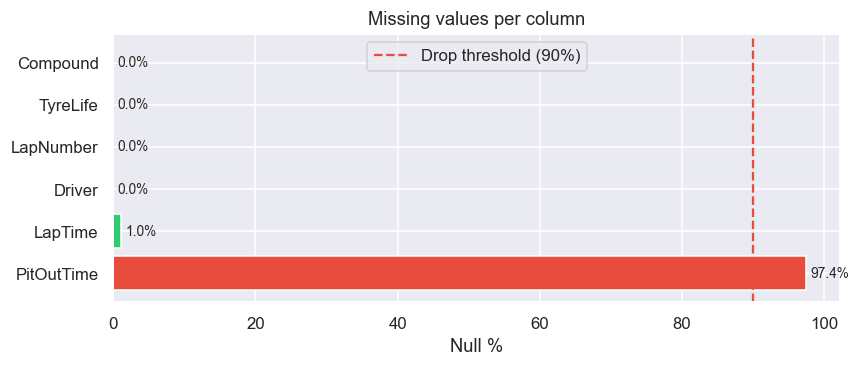


🗑️  Columns to drop (>90% null): ['PitOutTime']
   → PitOutTime has 933 nulls out of 958 rows (97.4%).  Dropping it is correct.


In [5]:
fig, ax = plt.subplots(figsize=(8, 3.5))
colors = ['#e74c3c' if v > NULL_PCT_THRESHOLD else '#2ecc71'
          for v in missing['null_pct']]
bars = ax.barh(missing.index, missing['null_pct'] * 100, color=colors)
ax.axvline(NULL_PCT_THRESHOLD * 100, color='#e74c3c', ls='--', lw=1.5,
           label=f'Drop threshold ({NULL_PCT_THRESHOLD:.0%})')
ax.bar_label(bars, fmt='%.1f%%', padding=3, fontsize=9)
ax.set_xlabel('Null %')
ax.set_title('Missing values per column')
ax.legend()
plt.tight_layout()
plt.show()

drop_cols = missing[missing['null_pct'] > NULL_PCT_THRESHOLD].index.tolist()
print(f'\n🗑️  Columns to drop (>{NULL_PCT_THRESHOLD:.0%} null): {drop_cols}')
print(f'   → PitOutTime has {missing.loc["PitOutTime","null_count"]} nulls out of {len(df_raw)} rows '
      f'({missing.loc["PitOutTime","null_pct"]:.1%}).  Dropping it is correct.')

In [6]:
# Save report
import os
os.makedirs('data', exist_ok=True)
missing.reset_index().rename(columns={'index': 'column'}).to_csv(
    'data/missing_report_italy_2023_r.csv', index=False
)
print('Saved → data/missing_report_italy_2023_r.csv')

Saved → data/missing_report_italy_2023_r.csv


---
## 3 · Target Engineering

FastF1 returns `LapTime` as a timedelta string (`'0 days 00:01:26.163000'`).  
We convert it to **seconds** which is a clean continuous target.

In [7]:
df = df_raw.drop(columns=drop_cols).copy()

# Parse LapTime
try:
    df['LapTime_Sec'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()
except Exception:
    df['LapTime_Sec'] = pd.to_numeric(df['LapTime'], errors='coerce')

before = len(df)
df = df.dropna(subset=['LapTime_Sec'])   # only rows where TARGET itself is missing
print(f'Dropped {before - len(df)} rows with unparseable LapTime. Remaining: {len(df):,}')

df = df.drop(columns=['LapTime'])
df[['LapTime_Sec']].describe().round(2)

Dropped 10 rows with unparseable LapTime. Remaining: 948


,LapTime_Sec
count,948.00
mean,87.77
std,3.60
min,85.07
25%,86.46
50%,87.04
75%,87.52
max,113.59


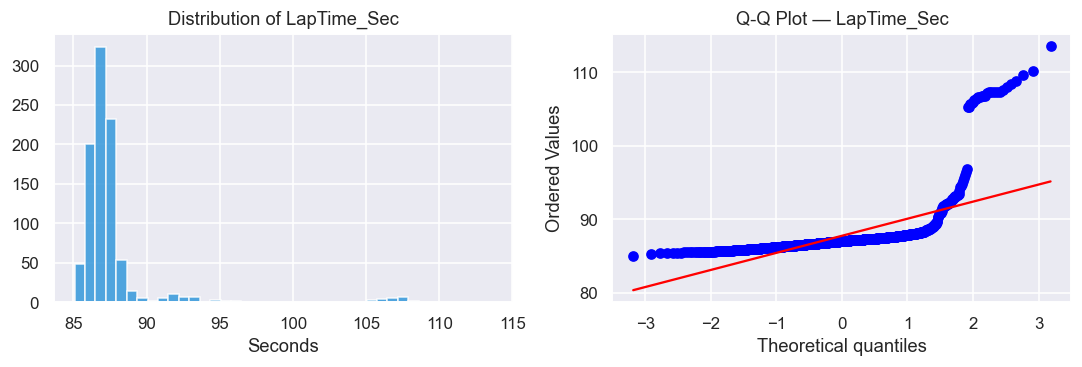

Skewness: 4.658  <- right-skewed, consider log transform


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(df['LapTime_Sec'], bins=40, color='#3498db', edgecolor='white', alpha=0.85)
axes[0].set_title('Distribution of LapTime_Sec')
axes[0].set_xlabel('Seconds')

stats.probplot(df['LapTime_Sec'], plot=axes[1])
axes[1].set_title('Q-Q Plot — LapTime_Sec')

plt.tight_layout()
plt.show()

sk = stats.skew(df['LapTime_Sec'])
skew_label = 'right-skewed, consider log transform' if sk > 1 else 'acceptable, no transform needed'
print(f'Skewness: {sk:.3f}  <- {skew_label}')


---
## 4 · Univariate Distributions

In [9]:
numeric_cols = df.select_dtypes(include=np.number).columns.drop('LapTime_Sec').tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()
print('Numeric features   :', numeric_cols)
print('Categorical features:', categorical_cols)

Numeric features   : ['LapNumber', 'TyreLife']
Categorical features: ['Driver', 'Compound']


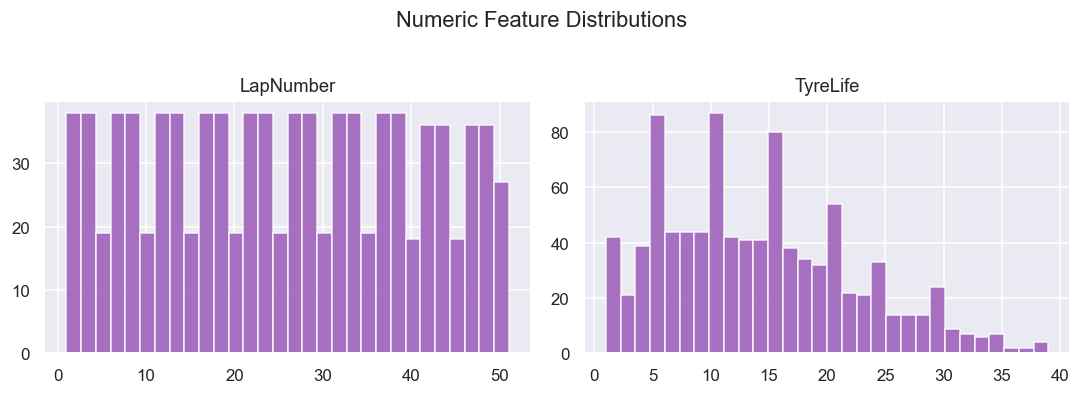

In [10]:
# Numeric — distributions
if numeric_cols:
    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(5 * len(numeric_cols), 3.5))
    if len(numeric_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, numeric_cols):
        ax.hist(df[col].dropna(), bins=30, color='#9b59b6', edgecolor='white', alpha=0.85)
        ax.set_title(col)
    plt.suptitle('Numeric Feature Distributions', y=1.02)
    plt.tight_layout()
    plt.show()

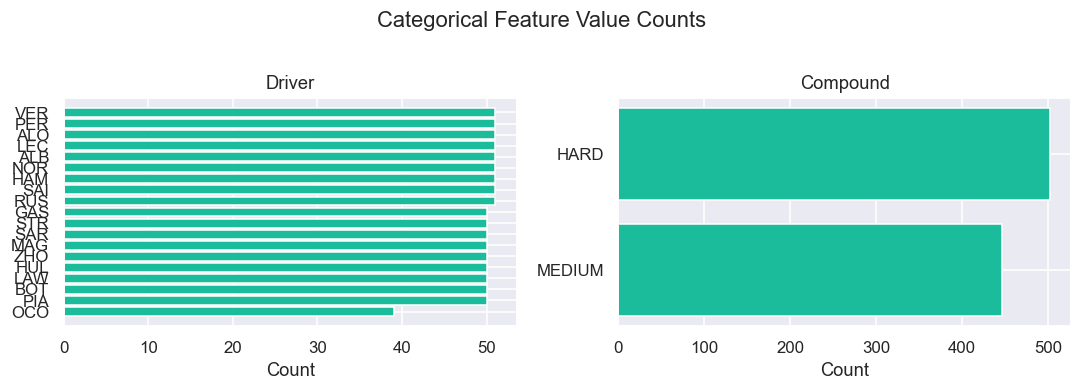

In [11]:
# Categorical — value counts
if categorical_cols:
    ncols = min(3, len(categorical_cols))
    nrows = int(np.ceil(len(categorical_cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3.5 * nrows))
    axes = np.array(axes).flatten()

    for ax, col in zip(axes, categorical_cols):
        vc = df[col].value_counts().head(20)
        ax.barh(vc.index[::-1], vc.values[::-1], color='#1abc9c')
        ax.set_title(col)
        ax.set_xlabel('Count')

    for ax in axes[len(categorical_cols):]:
        ax.axis('off')

    plt.suptitle('Categorical Feature Value Counts', y=1.01)
    plt.tight_layout()
    plt.show()

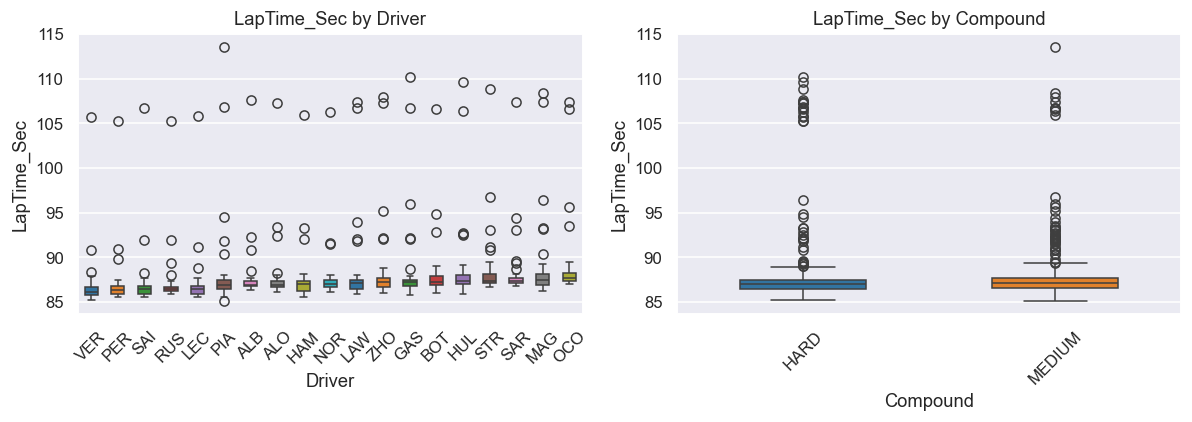

In [12]:
# LapTime by Compound — box plot
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

for ax, col in zip(axes, categorical_cols[:2]):
    order = df.groupby(col)['LapTime_Sec'].median().sort_values().index
    sns.boxplot(data=df, x=col, y='LapTime_Sec', order=order, ax=ax,
                palette='tab10', width=0.5)
    ax.set_title(f'LapTime_Sec by {col}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## 5 · Correlation Analysis

XGBoost is tree-based and is **invariant to monotone feature transformations**, so Pearson correlation gives a quick linear signal, but Spearman catches monotonic-nonlinear relationships too.

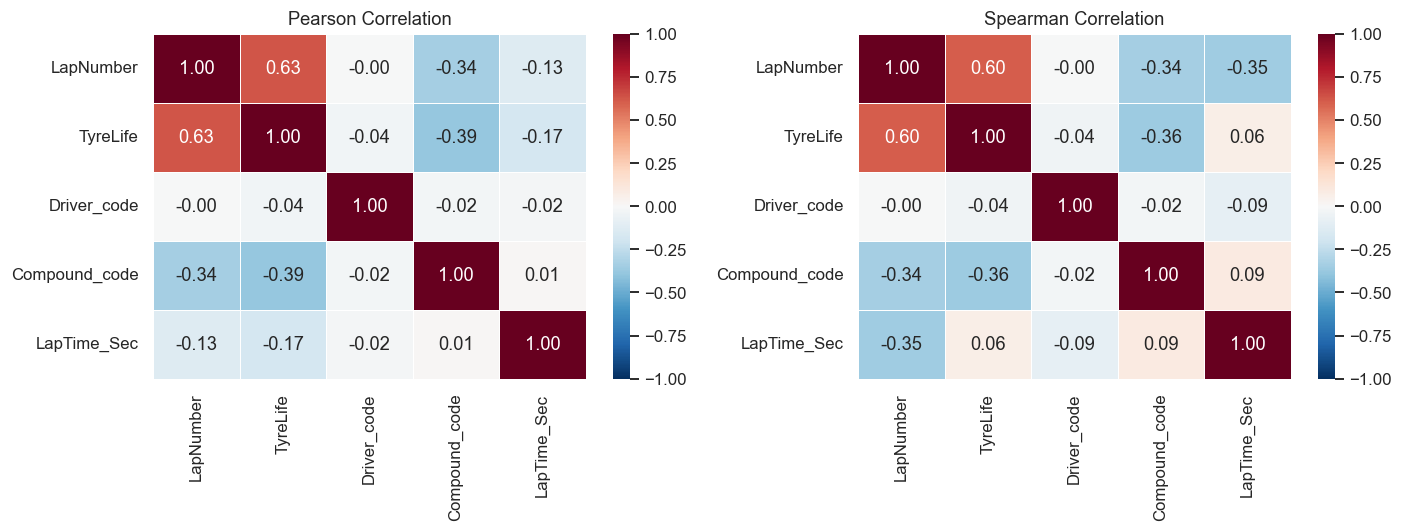

In [13]:
# Encode categoricals for correlation
df_enc = df.copy()
for col in categorical_cols:
    df_enc[col + '_code'] = df_enc[col].astype('category').cat.codes

corr_cols = numeric_cols + [c + '_code' for c in categorical_cols] + ['LapTime_Sec']
corr_pearson = df_enc[corr_cols].corr(method='pearson')
corr_spearman = df_enc[corr_cols].corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for ax, corr, title in zip(axes,
                            [corr_pearson, corr_spearman],
                            ['Pearson Correlation', 'Spearman Correlation']):
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, ax=ax, linewidths=0.5)
    ax.set_title(title)

plt.tight_layout()
plt.show()

Spearman |r| with LapTime_Sec:
LapNumber       -0.353265
Driver_code     -0.090349
Compound_code    0.088833
TyreLife         0.063676


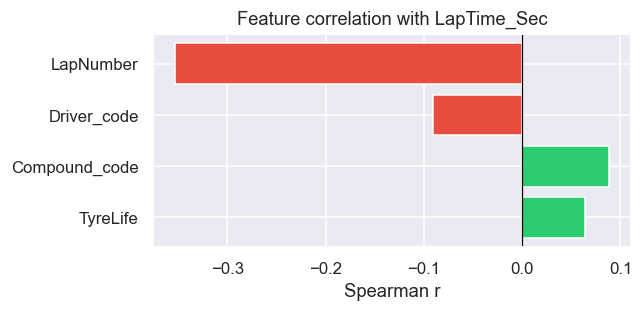

In [14]:
# Correlation with TARGET specifically
target_corr = corr_spearman['LapTime_Sec'].drop('LapTime_Sec').sort_values(key=abs, ascending=False)
print('Spearman |r| with LapTime_Sec:')
print(target_corr.to_string())

fig, ax = plt.subplots(figsize=(6, 3))
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in target_corr]
ax.barh(target_corr.index[::-1], target_corr.values[::-1], color=colors[::-1])
ax.axvline(0, color='black', lw=0.8)
ax.set_xlabel('Spearman r')
ax.set_title('Feature correlation with LapTime_Sec')
plt.tight_layout()
plt.show()

---
## 6 · Encoding & Normalisation

### Should we normalise for XGBoost?

| Model | Needs scaling? | Why |
|---|---|---|
| **XGBoost / GBDT** | ❌ No | Tree splits are rank-based; scale doesn't affect split quality |
| **Random Forest** | ❌ No | Same reason |
| **Ridge Regression** | ✅ Yes | Penalises coefficients by magnitude; unscaled features dominate |
| **Linear SVR / KNN** | ✅ Yes | Distance/dot-product sensitive to scale |

**Conclusion:** For our tree-based models, skip `StandardScaler` on numeric features. We include it below **only** for Ridge so the comparison is fair.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ── Preprocessor (no scaling) — for tree models ───────────────────────────
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe',    OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])
tree_preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols),
])

# ── Preprocessor (with scaling) — for linear models ───────────────────────
num_pipe_scaled = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()),
])
linear_preprocessor = ColumnTransformer([
    ('num', num_pipe_scaled, numeric_cols),
    ('cat', cat_pipe,        categorical_cols),
])

X = df.drop(columns=['LapTime_Sec'])
y = df['LapTime_Sec'].values

print(f'Feature matrix: {X.shape}')
print(f'Target vector : {y.shape}')

Feature matrix: (948, 4)
Target vector : (948,)


---
## 7 · Model Comparison

We compare 5 models using **5-fold cross-validation** on `MAE` and `RMSE`.

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    'Ridge':              Pipeline([('pre', linear_preprocessor),
                                    ('model', Ridge(alpha=1.0))]),
    'Random Forest':      Pipeline([('pre', tree_preprocessor),
                                    ('model', RandomForestRegressor(
                                        n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))]),
    'GradientBoosting':   Pipeline([('pre', tree_preprocessor),
                                    ('model', GradientBoostingRegressor(
                                        n_estimators=200, learning_rate=0.05, max_depth=4,
                                        random_state=RANDOM_STATE))]),
    'HistGradientBoosting': Pipeline([('pre', tree_preprocessor),
                                      ('model', HistGradientBoostingRegressor(
                                          max_iter=300, learning_rate=0.05, max_depth=5,
                                          random_state=RANDOM_STATE))]),
    'XGBoost':            Pipeline([('pre', tree_preprocessor),
                                    ('model', XGBRegressor(
                                        n_estimators=300, learning_rate=0.05, max_depth=5,
                                        subsample=0.8, colsample_bytree=0.8,
                                        random_state=RANDOM_STATE, n_jobs=-1,
                                        verbosity=0))]),
}

results = []
for name, pipe in models.items():
    mae_scores  = -cross_val_score(pipe, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    rmse_scores = np.sqrt(-cross_val_score(pipe, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1))
    results.append({
        'Model':    name,
        'MAE_mean': mae_scores.mean(),
        'MAE_std':  mae_scores.std(),
        'RMSE_mean':rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
    })
    print(f'{name:25s}  MAE={mae_scores.mean():.3f}±{mae_scores.std():.3f}s   RMSE={rmse_scores.mean():.3f}±{rmse_scores.std():.3f}s')

results_df = pd.DataFrame(results).sort_values('MAE_mean')
results_df.round(4)

Ridge                      MAE=1.780±0.064s   RMSE=3.560±0.272s


Random Forest              MAE=0.953±0.098s   RMSE=2.569±0.506s


GradientBoosting           MAE=0.977±0.052s   RMSE=2.444±0.448s


HistGradientBoosting       MAE=1.336±0.080s   RMSE=3.040±0.246s
XGBoost                    MAE=1.049±0.014s   RMSE=2.671±0.304s


,Model,MAE_mean,MAE_std,RMSE_mean,RMSE_std
1,Random Forest,0.9527,0.0980,2.5687,0.5061
2,GradientBoosting,0.9766,0.0518,2.4436,0.4483
4,XGBoost,1.0487,0.0144,2.6710,0.3036
3,HistGradientBoosting,1.3362,0.0798,3.0402,0.2461
0,Ridge,1.7804,0.0637,3.5603,0.2720


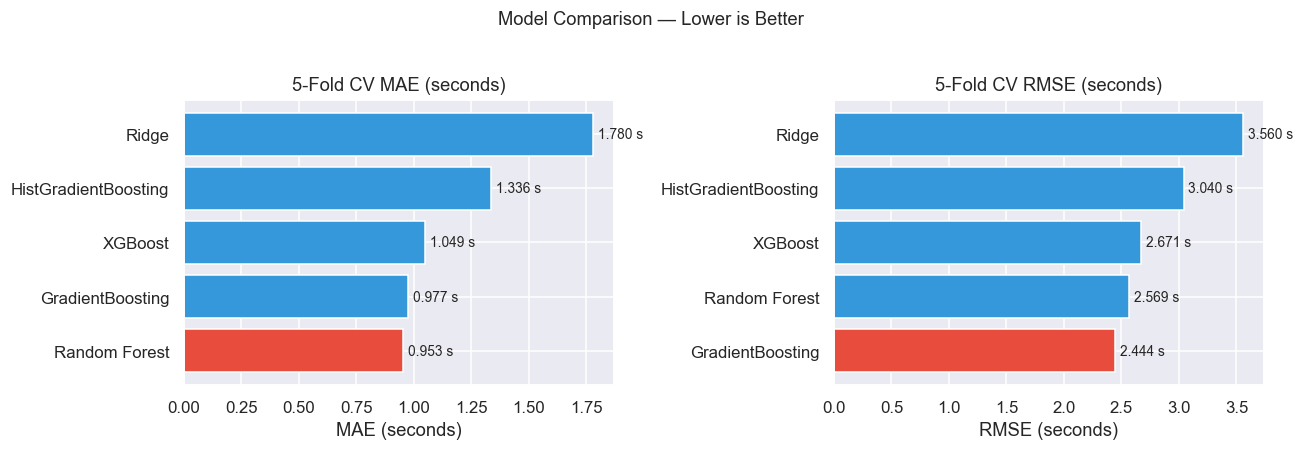

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, metric, label in zip(axes,
                              ['MAE_mean', 'RMSE_mean'],
                              ['MAE (seconds)', 'RMSE (seconds)']):
    df_plot = results_df.sort_values(metric, ascending=True)
    colors_ = ['#e74c3c' if m == df_plot[metric].min() else '#3498db'
               for m in df_plot[metric]]
    bars = ax.barh(df_plot['Model'], df_plot[metric], color=colors_)
    ax.bar_label(bars, fmt='%.3f s', padding=3, fontsize=9)
    ax.set_xlabel(label)
    ax.set_title(f'5-Fold CV {label}')

plt.suptitle('Model Comparison — Lower is Better', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

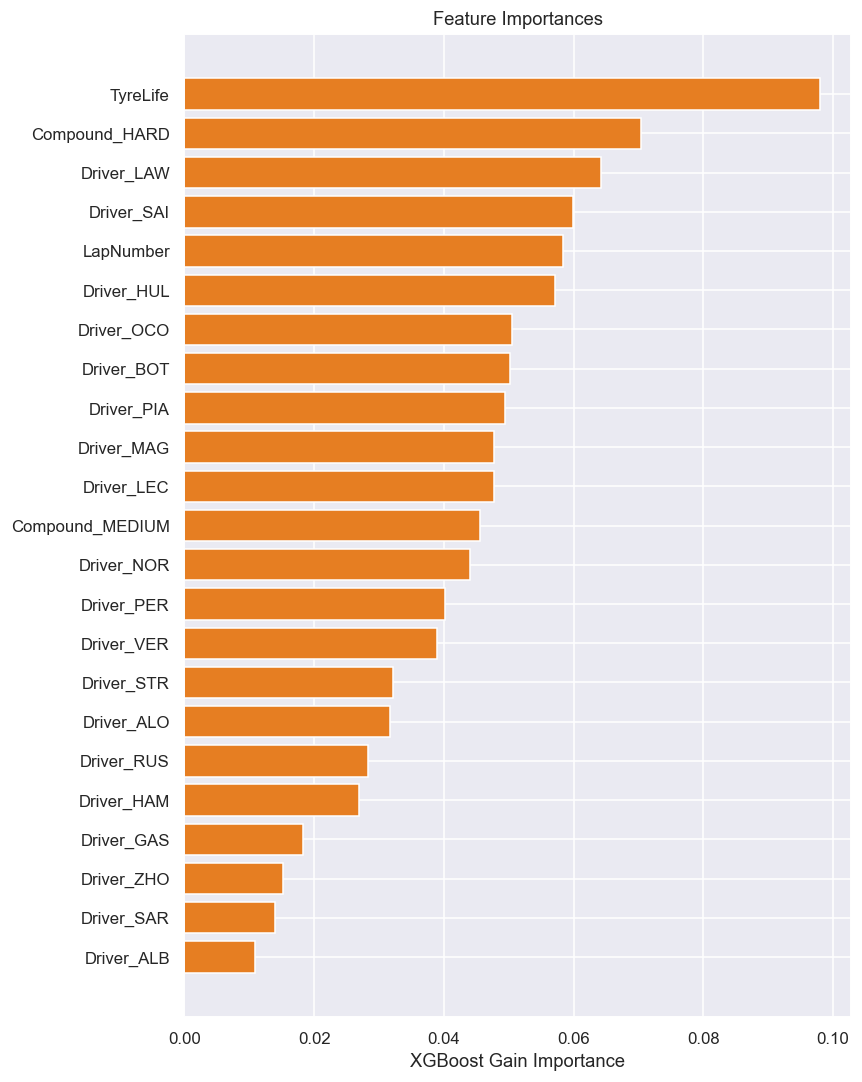

,feature,importance
0,TyreLife,0.097940
1,Compound_HARD,0.070437
2,Driver_LAW,0.064277
3,Driver_SAI,0.059985
4,LapNumber,0.058414
5,Driver_HUL,0.057169
6,Driver_OCO,0.050488
7,Driver_BOT,0.050228
8,Driver_PIA,0.049485
9,Driver_MAG,0.047701


In [18]:
# ── XGBoost: Feature importance ──────────────────────────────────────────────
import joblib, json

xgb_pipe = models['XGBoost']
xgb_pipe.fit(X, y)

pre = xgb_pipe.named_steps['pre']
ohe_names = list(pre.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_cols))
feature_names = numeric_cols + ohe_names

importances = xgb_pipe.named_steps['model'].feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, min(0.4 * len(imp_df) + 1, 10)))
ax.barh(imp_df['feature'][::-1], imp_df['importance'][::-1], color='#e67e22')
ax.set_xlabel('XGBoost Gain Importance')
ax.set_title('Feature Importances')
plt.tight_layout()
plt.show()

imp_df

---
## 8 · Takeaways & Recommended Pipeline

### Missing Values — What we found
| Column | Null % | Decision |
|---|---|---|
| `PitOutTime` | **97.4 %** | ❌ Drop — almost entirely empty, no signal |
| `LapTime` | 1.0 % | ⚠️ Target itself; rows with no target must be dropped |
| Others | 0 % | ✅ Keep as-is |

### Normalisation
- **Not needed** for XGBoost, Random Forest, GBDT (tree splits are rank-based).
- **Required** for Ridge and any linear/distance-based model.
- The `train_engine.py` preprocessing correctly omits scaling for the tree model.

### Recommended action for `train_engine.py`
The current `train_engine.py` pipeline already implements the recommended approach:
- `NULL_PCT_THRESHOLD = 0.90` to auto-drop high-null columns
- Median imputation for numeric, `'Unknown'` fill for categorical
- OHE with `handle_unknown='ignore'`
- Saves model + preprocessor + feature list for reproducible inference

In [19]:
# Save the best model artifacts (XGBoost unless another beats it)
best_model_name = results_df.iloc[0]['Model']
print(f'Best model by MAE: {best_model_name}')

best_pipe = models[best_model_name]
best_pipe.fit(X, y)

joblib.dump(best_pipe.named_steps['model'], 'engine_v1.joblib')
joblib.dump(best_pipe.named_steps['pre'],   'preprocessor_v1.joblib')

with open('feature_columns_v1.json', 'w') as f:
    json.dump(feature_names, f, indent=2)

print('Saved: engine_v1.joblib, preprocessor_v1.joblib, feature_columns_v1.json')

Best model by MAE: Random Forest
Saved: engine_v1.joblib, preprocessor_v1.joblib, feature_columns_v1.json
